# Prediction Model using XGBoost
The files have been generated in Databricks and provided on the S3 bucket

In [1]:
#!pip install boto3 # not required for Jupyter Notebooks on AWS infrastructure

In [2]:
import boto3

boto_session = boto3.Session() # Grabs session details directly from aws configuration in EC2 instance running the Notebook server
boto_session

Session(region_name='eu-central-1')

In [3]:
# Define variables for paths
s3_path = f"s3://sjf-project/"
output_path = s3_path + "estimator"

print(f"Using bucket '{s3_path}'.")

Using bucket 's3://sjf-project/'.


In [4]:
#!pip install sagemaker
import sagemaker

# Create a SageMaker Session
sagemaker_session = sagemaker.Session(boto_session=boto_session)

#The following IAM role ARN was taken from the flutz notebook listed in the SageMaker console:
sm_execution_role = 'arn:aws:iam::898627427171:role/service-role/AmazonSageMaker-ExecutionRole-20201106T104926'

In [5]:
# Use a previously-built, AWS XGBoost model for training

from sagemaker.amazon.amazon_estimator import get_image_uri
# container = get_image_uri(***insert correct arguments here***) 

container = get_image_uri(region_name=boto_session.region_name,
                          repo_name='xgboost',
                          repo_version='1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [6]:

# From https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html 
# XGBoost ecr path is: 492215442770.dkr.ecr.eu-central-1.amazonaws.com
ecr_path = '492215442770.dkr.ecr.eu-central-1.amazonaws.com'

#'ml.m4.xlarge') | 'ml.t2.medium' || train_instance_type= "ml.m5.large" -> "ml.m5.xlarge"
#Instance Name	vCPU	ECU	RAM   	Instance-GB	Linux/UNIX-Nutzung
#t2.medium	2	Var.	4 GiB	Nur EBS 	0,0536 USD pro Stunde
#m4.xlarge	4	13	16 GiB	Nur EBS 	0,24 USD pro Stunde
#m5.large	2	10	8 GiB	Nur EBS 	0,115 USD pro Stunde
#m5.xlarge	4	16	16 GiB	Nur EBS 	0,23 USD pro Stunde
xgboost = sagemaker.estimator.Estimator(f"{ecr_path}/sagemaker-xgboost:1.0-1-cpu-py3",
                              sm_execution_role,
                              train_instance_count=1,
                              train_instance_type="ml.m5.xlarge",
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              base_job_name="sjf-xgboost")


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [7]:
# Create pointers to the S3 train and test datasets

from sagemaker.session import s3_input

Train = 'train_data.csv'
Valid = 'valid_data.csv'

s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}{Train}", content_type="text/csv")
s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}{Valid}", content_type="text/csv")
#s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}train_sample.csv", content_type="text/csv")
#s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}valid_sample.csv", content_type="text/csv")
#s3_input_test = sagemaker.session.s3_input(s3_data=f"{s3_path}test.csv", content_type="text/csv")

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [8]:
# Create an XGBoost Estimator

# From https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html 
# XGBoost ecr path is: 492215442770.dkr.ecr.eu-central-1.amazonaws.com
ecr_path = '492215442770.dkr.ecr.eu-central-1.amazonaws.com'

#'ml.m4.xlarge') | 'ml.t2.medium' || train_instance_type= "ml.m5.large" -> "ml.m5.xlarge"
#Instance Name	vCPU	ECU	RAM   	Instance-GB	Linux/UNIX-Nutzung
#t2.medium	2	Var.	4 GiB	Nur EBS 	0,0536 USD pro Stunde
#m4.xlarge	4	13	16 GiB	Nur EBS 	0,24 USD pro Stunde
#m5.large	2	10	8 GiB	Nur EBS 	0,115 USD pro Stunde
#m5.xlarge	4	16	16 GiB	Nur EBS 	0,23 USD pro Stunde
xgboost = sagemaker.estimator.Estimator(f"{ecr_path}/sagemaker-xgboost:1.0-1-cpu-py3",
                              sm_execution_role,
                              train_instance_count=1,
                              train_instance_type="ml.m5.xlarge",
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              base_job_name="sjf-xgboost")


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [9]:
# Select the your specific hyperparameters (Optional)

# From https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

xgboost.set_hyperparameters(
    eta=0.3,                         # default 0.3 range 0 - 1   
    num_round=30,                    # required | valid values: int | The number of rounds to run the training.
    objective = 'reg:squarederror'  # Examples: reg:linear, reg:logistic, multi:softmax, reg:squarederror [default] 
)

In [10]:
# Fit the model

xgboost.fit({"train": s3_input_train})


2020-11-19 18:55:25 Starting - Starting the training job...
2020-11-19 18:55:29 Starting - Launching requested ML instances......
2020-11-19 18:56:33 Starting - Preparing the instances for training...
2020-11-19 18:57:23 Downloading - Downloading input data
2020-11-19 18:57:23 Training - Downloading the training image...
2020-11-19 18:57:45 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[18:57:53] 401132x429 matrix with 172085628 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimi

In [11]:
# Deploy your model to an endpoint to perform predictions

Predictor = xgboost.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.t2.medium')
    

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [12]:
Predictor.endpoint

'sjf-xgboost-2020-11-19-18-55-25-404'

In [13]:
# Configure the predictor's serializer and deserializer

from sagemaker.predictor import csv_serializer, csv_deserializer

Predictor.serializer = csv_serializer
Predictor.deserializer = csv_deserializer
Predictor.content_type = "text/csv"

In [14]:
Predictor.endpoint

'sjf-xgboost-2020-11-19-18-55-25-404'

# Predictions

In [15]:
# Import the validate dataset into a dataframe

import pandas as pd

validate_df = pd.read_csv(f"{s3_path}{Valid}", header=None)
display(validate_df)

,0,1,2,3,4,5,6,7,8,9,...,420,421,422,423,424,425,426,427,428,429
0,6.9,1668,0,1894,1894,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,6.9,214,0,1895,1895,1,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,6.9,17,0,1898,1898,60,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,6.9,14,0,1896,1896,60,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,6.9,49,0,1896,1896,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6.9,103,0,1929,1929,64,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
996,6.9,48,0,1930,1930,80,9,1,0,0,...,0,0,0,0,0,0,0,0,0,0
997,6.9,73,0,1930,1930,55,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
998,6.9,10,0,1931,1931,82,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
train_df = pd.read_csv(f"{s3_path}{Train}", header=None)
display(train_df)

MemoryError: Unable to allocate 1.28 GiB for an array with shape (429, 401132) and data type int64

In [17]:
validate_df.iloc[0, 1:]

1      1668.0
2         0.0
3      1894.0
4      1894.0
5         1.0
        ...  
425       0.0
426       0.0
427       0.0
428       0.0
429       0.0
Name: 0, Length: 429, dtype: float64

In [18]:
prediction = Predictor.predict(validate_df.iloc[0:, 1:].values)
#len(prediction[0])

In [19]:
#y_predicted = list(map(lambda pred: round(float(pred),1), prediction[0])) # prediction-Werte werde auf eine Kommastelle gerundet
y_predicted = list(map(float, prediction[0]))
display(y_predicted)

[6.899407863616943,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.899872303009033,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.899688720703125,
 6.8998637199401855,
 6.8998637199401855,
 6.8998637199401855,
 6.929965496063232,
 6.8998637199401855,
 6.8998637199401855,
 6.899855136871338,
 6.8998637199401855,
 6.899836540222168,
 6.8998637199401855,
 6.8998637199401855

In [20]:
y_true = validate_df[0].values
display(y_true)

array([6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 7.1, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9,
       6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.9, 6.

In [21]:
from sklearn.metrics import r2_score
print(r2_score(y_true, y_predicted))

0.07137434922222496


In [22]:
from sklearn.metrics import explained_variance_score
print(explained_variance_score(y_true, y_predicted))

0.07320491659590511


In [23]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true, y_predicted)
print(mse)

8.349273226142934e-05


In [24]:
import numpy as np
rootMeanSquaredError = np.sqrt(mse)
print("RMSE:", rootMeanSquaredError)

RMSE: 0.009137435759633517


In [25]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_true, y_predicted))

0.000786535739899029


In [26]:
pred=[]
pred_df = pd.DataFrame(y_predicted, columns=['prediction'])
pred_df['ground_truth']=y_true
display(pred_df.tail(10))

,prediction,ground_truth
990,6.899855,6.9
991,6.899837,6.9
992,6.899864,6.9
993,6.899864,6.9
994,6.899864,6.9
995,6.899864,6.9
996,6.899855,6.9
997,6.899864,6.9
998,6.899864,6.9
999,6.899864,6.9


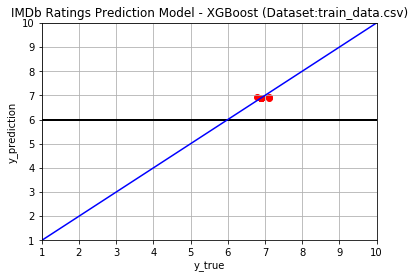

In [27]:
import matplotlib.pyplot as plt

x = y_true
y = y_predicted
plt.scatter(x, y, color="red")
plt.title(f"IMDb Ratings Prediction Model - XGBoost (Dataset:{Train})")
plt.xlabel("y_true")
plt.ylabel("y_prediction")
plt.xlim([1,10])
plt.ylim([1,10])
plt.axhline(y=6, xmin=0, xmax=10, linewidth=2, color = 'k')
plt.plot([1,10],[1,10], color="blue")
plt.grid()
plt.show()